In [32]:
import os
import numpy as np
import pandas as pd
import pprint as pp
import random
import rapidfuzz
# functions for reading data from codenet:
import codenet_reader

In [33]:
# Functions for processing solutions of a problem


def pair_series(
    series_1: pd.Series,
    series_2: pd.Series,
    col_1_name: str,
    col_2_name: str,
    shuffle: bool = True,
) -> pd.DataFrame:
    assert len(series_1) == len(series_2), "Length of the series MUST match!"

    if shuffle:
        series_1 = series_1.sample(frac=1.0, ignore_index=True)
        series_2 = series_2.sample(frac=1.0, ignore_index=True)

    return pd.DataFrame({
        col_1_name: series_1.to_list(),
        col_2_name: series_2.to_list(),
    })


def process_pid(pid: str, pp_data_map: dict, np_data_map: dict):
    MIN_PAIRS = 2

    num_python_solutions = len(codenet_reader.python_solutions(pid))
    if num_python_solutions <= 5:
        return

    df = codenet_reader.init_metadata_df(pid)
    if df is None:
        print("ERROR: Problem metadata could not be loaded!"+
              f"\n(problem ID: {pid})\n")
        return

    df_accepted = df.loc[df["status"] == "Accepted"]
    # ONLY sample from solutions that are actually wrong
    df_rejected = df.loc[df["status"] == "Wrong Answer"]

    print(f"{pid}", "-" * 50)
    print(" accepted:", df_accepted.shape[0])
    print(" rejected:", df_rejected.shape[0])
    
    num_rows = min(df_accepted.shape[0], df_rejected.shape[0])
    if not num_rows or num_rows < 2 * MIN_PAIRS:
        return

    half = df_accepted.shape[0] // 2
    sr_accepted = df_accepted["submission_id"]  # all accepted IDs
    sr_accepted = sr_accepted[: 2 * half]
    # Positive pairs
    df_pp = pair_series(sr_accepted[:half], sr_accepted[half:], "sid_1", "sid_2")

    sr_accepted = df_accepted["submission_id"].sample(n=num_rows)  # num_rows IDs
    sr_rejected = df_rejected["submission_id"].sample(n=num_rows)  # num_rows IDs
    # Negative pairs
    df_np = pair_series(sr_accepted, sr_rejected, "sid_1", "sid_2", shuffle=False)

    def create_pair(pid, sid_1, sid_2, label: int):
        return {
            "pid": pid,
            "sid_1": sid_1,
            "sid_2": sid_2,
            "src_1": codenet_reader.read_solution_file(pid, sid_1),
            "src_2": codenet_reader.read_solution_file(pid, sid_2),
            "label": label,
        }

    pp_rows = [tuple(row) for _, row in df_pp.iterrows()]
    pp_data_map[pid] = [
        create_pair(pid, sid_1, sid_2, label=1) for sid_1, sid_2 in pp_rows
    ]

    np_rows = [tuple(row) for _, row in df_np.iterrows()]
    np_data_map[pid] = [
        create_pair(pid, sid_1, sid_2, label=0) for sid_1, sid_2 in np_rows
    ]


def test():
    process_pid("p03200", {}, {})

In [34]:
test()

p03200 --------------------------------------------------
 accepted: 612
 rejected: 103


In [35]:
# Reading data

SAMPLE_SIZE = 2000

_pids = os.listdir(codenet_reader.DATA_PATH)
_pids = random.sample(_pids, k=min(SAMPLE_SIZE, len(_pids)))

pp_data = {}
np_data = {}

print("Starting...")
print(f"Processing {len(_pids)} problems.")

for _pid in _pids:
    process_pid(_pid, pp_data, np_data)

print("Data gathered...")

pp_output = []
for pid in pp_data:
    for data in pp_data[pid]:
        pp_output.append(
            (
                pid,
                data["sid_1"],
                data["sid_2"],
                data["src_1"],
                data["src_2"],
                data["label"],
            )
        )

np_output = []
for pid in np_data:
    for data in np_data[pid]:
        np_output.append(
            (
                pid,
                data["sid_1"],
                data["sid_2"],
                data["src_1"],
                data["src_2"],
                data["label"],
            )
        )

print(f"POSITIVE pairs created... LENGTH: {len(pp_output)}")
print(f"NEGATIVE pairs created... LENGTH: {len(np_output)}")

pp_output = sorted(set(pp_output), key=lambda x: (x[0], x[1]))
np_output = sorted(set(np_output), key=lambda x: (x[0], x[1]))

pp_len, np_len = len(pp_output), len(np_output)

print(f"POSITIVE pair content filtered... LENGTH: {pp_len}")
print(f"NEGATIVE pair content filtered... LENGTH: {np_len}")

print("DONE")

columns = ["pid", "sid_1", "sid_2", "src_1", "src_2", "label"]
# positive pairs
pp_output = pd.DataFrame(pp_output, columns=columns)
# negative pairs
np_output = pd.DataFrame(np_output, columns=columns)

Starting...
Processing 2000 problems.
p00469 --------------------------------------------------
 accepted: 3
 rejected: 0
p00770 --------------------------------------------------
 accepted: 0
 rejected: 0
p00628 --------------------------------------------------
 accepted: 63
 rejected: 0
p03212 --------------------------------------------------
 accepted: 966
 rejected: 174
p02497 --------------------------------------------------
 accepted: 0
 rejected: 0
p03268 --------------------------------------------------
 accepted: 229
 rejected: 28
p00192 --------------------------------------------------
 accepted: 0
 rejected: 0
p02574 --------------------------------------------------
 accepted: 1137
 rejected: 2263
p03479 --------------------------------------------------
 accepted: 613
 rejected: 242
p03277 --------------------------------------------------
 accepted: 14
 rejected: 17
p03141 --------------------------------------------------
 accepted: 278
 rejected: 158
p02251 -------

In [36]:
# Calculating rapid fuzz

def run_rf(a,b): return rapidfuzz.fuzz.ratio(a,b)

pp_output['rf_ratio'] = pp_output.apply(lambda row: run_rf(row['src_1'], row['src_2']), axis=1)
np_output['rf_ratio'] = np_output.apply(lambda row: run_rf(row['src_1'], row['src_2']), axis=1)

In [37]:
# Rapid fuzz counts
print('pp gt 80%:', (pp_output['rf_ratio']>80).sum())
print('np gt 80%:', (np_output['rf_ratio']>80).sum())

pp gt 80%: 19940
np gt 80%: 3629


Text(0.5, 0, 'rf ratio on positive pairs')

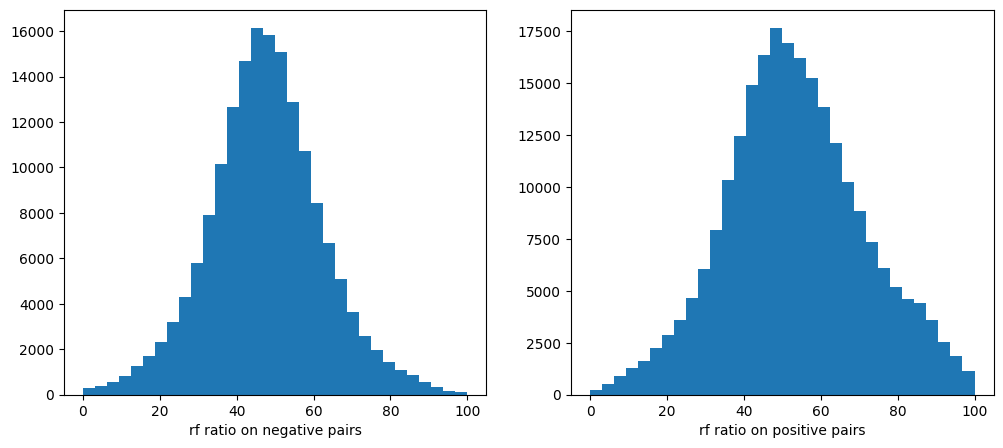

In [38]:
# Rapid fuzz histograms
import matplotlib.pyplot as plt
res = 32
# histogram
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax[0].hist(np_output['rf_ratio'], bins=res)
ax[0].set_xlabel('rf ratio on negative pairs')
ax[1].hist(pp_output['rf_ratio'], bins=res)
ax[1].set_xlabel('rf ratio on positive pairs')

In [39]:
# Filtering and sampling
pp_output = pp_output.sample(5000)
#np_output = np_output[np_output['rf_ratio'] > 80]
np_output = np_output.sample(5000)

In [40]:
# Exporting
EXPORTED_FILE_NAME = 'output_paired.csv'
pp_output = pp_output[columns]
np_output = np_output[columns]
output = pd.concat([pp_output, np_output], ignore_index=True)
output.to_csv(EXPORTED_FILE_NAME)

In [41]:
df = pd.read_csv(EXPORTED_FILE_NAME)
len(set(df['pid']))

502